# HLE Final Project

## SemEval 2020 - Task 6: DeftEval: Extracting term-definition pairs in free text

### Authors: Hasan Evci and Paweł Koźmiński 

### import libraries

In [1]:
import pandas as pd
import torch
import transformers
from transformers import BertTokenizer, BertModel
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tqdm import tqdm, trange

C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### config object containing important parameters and model parameters to configure

In [2]:
class Config(object):
    dev = False
    use_data_augmentation = True

    if use_data_augmentation:
        train_path = "data/train_augmentation.csv" #"data/train_oversampling.csv"
    else:
        train_path = "data/train.csv"
    validation_path = "data/validation.csv"
    test_path = "data/test.csv"

    # model / optimizer parameters
    bert_model: str = 'allenai/scibert_scivocab_cased' #all considered models: 'allenai/scibert_scivocab_cased' ,'bert-base-cased','roberta-base'
    use_crf = True # toggle if crf classifier should be used instead of linear classifier
    full_finetuning: bool = True # toggle if all hyperparameters are fine-tuned. if False only parameters of classifier are fine-tuned
    epochs: int = 5 # number of epochs
    sequence_length: int = 512 # sequence length of the bert model
    batch_size: int = 16 # batch size used during training / testing
    hidden_dropout_prob: float = 0.1 # hidden dropout probability, BERT default is 0.1
    lr: float = 5e-5 # lerning rate, best feeling: 4.5e-5 or 5e-5, best values were between 1e-5 and 6e-5
    eps: float = 1e-8 # Adams epsilon parameter for numerical stability
    warmup_steps: int = 0 # warm up steps 
    max_grad_norm: float = 1.0 # clip the norm of the gradient

    update_step = 100
    
config = Config()

### get training and validation dataloader (external python script handles this)

In [3]:
from get_dataloader import get_dataloader
train_dataloader, tag_values, tag2idx = get_dataloader(config.train_path, 
                                                      data_kind="train", 
                                                      tag_values=None,
                                                      bert_model=config.bert_model, 
                                                      dev=config.dev, 
                                                      sequence_length=config.sequence_length, 
                                                      batch_size=config.batch_size)

validation_dataloader, _, _ = get_dataloader(config.validation_path, 
                                                      data_kind="validation", 
                                                      tag_values=tag_values,
                                                      bert_model=config.bert_model, 
                                                      dev=config.dev, 
                                                      sequence_length=config.sequence_length, 
                                                      batch_size=config.batch_size)

C:\Users\Hasan\Desktop\Barcelona_Data\FIB_Courses\HLE\Project\code_repo_new\HLE_Project\get_dataloader.py:324: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, encoding="utf-8").fillna(method="ffill")


{'O': 361479, 'B-Definition': 7244, 'I-Definition': 105540, 'B-Term': 7943, 'I-Term': 11232, 'B-Alias-Term': 870, 'I-Alias-Term': 1093, 'B-Secondary-Definition': 593, 'I-Secondary-Definition': 9826, 'B-Ordered-Term': 5, 'I-Ordered-Term': 13, 'B-Ordered-Definition': 5, 'I-Ordered-Definition': 51, 'B-Referential-Definition': 964, 'I-Referential-Definition': 2128, 'B-Qualifier': 840, 'I-Qualifier': 4801, 'B-Referential-Term': 848, 'B-Definition-frag': 89, 'I-Definition-frag': 975, 'I-Referential-Term': 991, 'B-Term-frag': 24, 'B-Alias-Term-frag': 15, 'I-Term-frag': 3}

Total sentences:  25945
Total labels:  517572

Following tags and their corresponding IDs will be used:  {'B-Alias-Term': 0, 'B-Alias-Term-frag': 1, 'B-Definition': 2, 'B-Definition-frag': 3, 'B-Ordered-Definition': 4, 'B-Ordered-Term': 5, 'B-Qualifier': 6, 'B-Referential-Definition': 7, 'B-Referential-Term': 8, 'B-Secondary-Definition': 9, 'B-Term': 10, 'B-Term-frag': 11, 'I-Alias-Term': 12, 'I-Definition': 13, 'I-Definiti

### Check if cuda gpu exists and if yes assign device to gpu, otherwise to cpu

In [4]:
def select_cuda():
    """for acceleration of the training cuda is used (gpu support)
    
    Returns:
        TYPE: Description
    """
    # if cuda is available, use gpu instead of the cpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, "will be used", "\n")

    #get amount of gpus
    n_gpu = torch.cuda.device_count()
    print("There is (are)", n_gpu, "GPU(s) available", "\n")

    # get the GPU name
    gpu_name = torch.cuda.get_device_name(0)
    if n_gpu != 0:
        print("The GPU: '", gpu_name, "' will be used", "\n")

    return device, n_gpu

# select cuda for gpu support later in the training phase (to have faster training)
device, n_gpu = select_cuda()

cuda will be used 

There is (are) 1 GPU(s) available 

The GPU: ' NVIDIA GeForce RTX 3050 Laptop GPU ' will be used 



### Define BERT-CRF and RoBERTa-CRF model architecture

In [5]:
from transformers import BertPreTrainedModel, BertModel
from transformers import RobertaPreTrainedModel, RobertaModel
from torchcrf import CRF 

class Bert_CRF(BertPreTrainedModel):

    """a class summarizing the model architecture when crf is used on top of bert.
    
    Attributes:
        bert (TYPE): the pretrained bert model to be used
        classifier (TYPE): the classifier to be used on top of the pretrained bert model
        crf (TYPE): the conditional random field to be used for the classifiers outputs
        dropout (TYPE): dropout with its probability
        num_labels (TYPE): number of labels to be used 
    """

    def __init__(self, config):
        super(Bert_CRF, self).__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob) # 0.1 is default by BERT
        self.classifier = torch.nn.Linear(config.hidden_size, self.num_labels)
        self.init_weights()
        self.crf = CRF(self.num_labels, batch_first=True)    
    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):  
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        emission = self.classifier(sequence_output)    
        attention_mask = attention_mask.type(torch.uint8) # change to needed tensor
        if labels is not None:
            labels = labels.type(torch.long)      
            loss = -self.crf(emission, labels, mask=attention_mask, reduction='mean')
            return loss
        else:
            prediction = self.crf.decode(emission, mask=attention_mask)
            return prediction
        
class Roberta_CRF(RobertaPreTrainedModel):

    """a class summarizing the model architecture when crf is used on top of bert.
    
    Attributes:
        bert (TYPE): the pretrained bert model to be used
        classifier (TYPE): the classifier to be used on top of the pretrained bert model
        crf (TYPE): the conditional random field to be used for the classifiers outputs
        dropout (TYPE): dropout with its probability
        num_labels (TYPE): number of labels to be used 
    """

    def __init__(self, config):
        super(Roberta_CRF, self).__init__(config)
        self.num_labels = config.num_labels
        self.bert = RobertaModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob) # 0.1 is default by BERT
        self.classifier = torch.nn.Linear(config.hidden_size, self.num_labels)
        self.init_weights()
        self.crf = CRF(self.num_labels, batch_first=True)    
    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):  
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        emission = self.classifier(sequence_output)    
        attention_mask = attention_mask.type(torch.uint8) # change to needed tensor
        if labels is not None:
            labels = labels.type(torch.long)      
            loss = -self.crf(emission, labels, mask=attention_mask, reduction='mean')
            return loss
        else:
            prediction = self.crf.decode(emission, mask=attention_mask)
            return prediction

### initialize model and assign it to cuda

In [6]:
from transformers import BertForTokenClassification, RobertaForTokenClassification

def initialize_model(tag2idx):
    """here the two specified models of this repository are initialized:
    either BERT + BertForTokenClassification (linear layer) or BERT + CRF
    
    Args:
        tag2idx (TYPE): Description
    
    Returns:
        TYPE: Description
    """
    if config.use_crf:
        if not "roberta" in config.bert_model:
            model = Bert_CRF.from_pretrained(
                config.bert_model,  # pretrained model
                num_labels=len(tag2idx), # amount of labels passed (for BertConfig)
                output_attentions = False, # Whether or not to return the attentions tensors of all attention layers. 
                output_hidden_states = False # Whether or not to return the hidden states of all layers.
            )
        else:
            model = Roberta_CRF.from_pretrained(
                config.bert_model,  # pretrained model
                num_labels=len(tag2idx), # amount of labels passed (for BertConfig)
                output_attentions = False, # Whether or not to return the attentions tensors of all attention layers. 
                output_hidden_states = False # Whether or not to return the hidden states of all layers.
            )
    else:
        # The transformer package provides a BertForTokenClassification class for token-level predictions. 
        # BertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier 
        # on top of the BertModel. The token-level classifier is a linear layer that takes as input the last hidden state 
        # of the sequence. Same applies analogously for RobertaForTokenClassification on top of the RoBERTa model
        if not "roberta" in config.bert_model:
            model = BertForTokenClassification.from_pretrained(
               config.bert_model,  # pretrained model, other option: 'bert-base-cased' etc.
               num_labels=len(tag2idx), # amount of labels passed (prob. for BertConfig)
               output_attentions = False, # Whether or not to return the attentions tensors of all attention layers. 
               output_hidden_states = False # Whether or not to return the hidden states of all layers.
            )
        else:
            model = RobertaForTokenClassification.from_pretrained(
           config.bert_model,  # pretrained model, other option: 'bert-base-cased' etc.
           num_labels=len(tag2idx), # amount of labels passed (prob. for BertConfig)
           output_attentions = False, # Whether or not to return the attentions tensors of all attention layers. 
           output_hidden_states = False # Whether or not to return the hidden states of all layers.
            )

    #Pass the model parameters to the GPU (faster computations)
    model.cuda();

    return model

# empty the cuda (gpu) cache
torch.cuda.empty_cache()

# initialize the BERT model
model = initialize_model(tag2idx)

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing Bert_CRF: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing Bert_CRF from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Bert_CRF from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Bert_CRF were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are

### initialize AdamW optimizer

##### The AdamW optimizer decouples the weight decay from the gradient update. This means that the weight decay and learning rate can be optimized separately. This leads to better model generalization.

In [7]:
from transformers import AdamW

def initialize_optimizer(model):
    """Having the initialized model as input, this method initializes an optimizer
    
    Args:
        model (TYPE): Description
    
    Returns:
        TYPE: Description
    """
    # Before we can start the fine-tuning process, we have to setup the optimizer and add the parameters it should update. 
    # A common choice is the AdamW optimizer. weight_decay is added as regularization to the main weight matrices. 
    if config.full_finetuning:
        # Returns an iterator over module parameters, yielding both the name of the parameter as well as the parameter itself.
        param_optimizer = list(model.named_parameters()) # all parameters to be optimized
        
        # there are different types of model parameters in model.named_parameters(). for the 3 values bias, gamma, beta
        # there should be no decay in the learning rate of these paramters. For all other parameters the decay is 0.01
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01}, # was 0.01
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0}
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters()) # only optimize parameters of classifier
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

    # pass the parameters to the AdamW optimizer, define learning rate, define epsilon ?
    optimizer = AdamW(
        optimizer_grouped_parameters, # parameters
        lr=config.lr, # learning rate
        eps=config.eps # epsilon: very small number to prevent any division by zero in the implementation
    )

    return optimizer

# initialize the AdamW optimizer
optimizer = initialize_optimizer(model)

C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### initialize scheduler

In [8]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is number of batches * number of epochs. (for scheduler)
total_steps = len(train_dataloader) * config.epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config.warmup_steps,
    num_training_steps=total_steps
)

### methods for saving checkpoints and calculating relevant metrics and further auxiliary methods

In [9]:
import time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def save_checkpoint(epoch, model, optimizer, scheduler, tag_values, loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores, save_config=False): #TODO update doc
    """method for saving a checkpoint of model training and if wanted the config values, too
    
    Args:
        epoch (TYPE): current epoch
        model (TYPE): current model (parameters)
        optimizer (TYPE): current optimizer (parameters)
        scheduler (TYPE): current scheduler (parameters)
        tag_values (TYPE): used tag_values
        loss_values (TYPE): so far all collected loss values
        validation_loss_values (TYPE): so far all collected validation loss values
    """
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'tag_values': tag_values,
        'loss_values': loss_values,
        'validation_loss_values': validation_loss_values,
        'precision_scores': precision_scores,
        'recall_scores': recall_scores,
        'f1_scores': f1_scores,
        'config': config
    }
    torch.save(state, 'model_checkpoints/checkpoint_{model}_{ep}.pt'.format(model = config.bert_model, ep = epoch)) # does not work for scibert because '/' is in pretrained model name

def calculate_relevant_metrics(y_true: list, y_pred: list, tag2idx: dict):
    """The classification metrics precision, recall and f1-score are calculated and returned.
    If wanted a classification report can be returned. It contains the above mentioned metrics
    for all labels.
    
    Args:
        y_true (list): Description
        y_pred (list): Description
        tag_values (list): Description
        report_wanted (bool, optional): Description
    
    Returns:
        TYPE: Description
    """
    
    y_true = [item for sublist in y_true for item in sublist]
    y_pred = [item for sublist in y_pred for item in sublist]
    
    relevant_labels_for_evaluation = [tag2idx['B-Term'], tag2idx['I-Term'], tag2idx['B-Definition'], tag2idx['I-Definition'], tag2idx['B-Alias-Term'], tag2idx['I-Alias-Term'], tag2idx['B-Referential-Definition'], tag2idx['I-Referential-Definition'], tag2idx['B-Referential-Term'], tag2idx['I-Referential-Term'], tag2idx['B-Qualifier'], tag2idx['I-Qualifier']]
    
    current_precision_score = precision_score(y_true, y_pred, labels=relevant_labels_for_evaluation, average="macro")
    current_recall_score = recall_score(y_true, y_pred, labels=relevant_labels_for_evaluation, average="macro")
    current_f1_score = f1_score(y_true, y_pred, labels=relevant_labels_for_evaluation, average="macro")
    
    current_precision_score2 = precision_score(y_true, y_pred, labels=relevant_labels_for_evaluation, average="micro")
    current_recall_score2 = recall_score(y_true, y_pred, labels=relevant_labels_for_evaluation, average="micro")
    current_f1_score2 = f1_score(y_true, y_pred, labels=relevant_labels_for_evaluation, average="micro")
    
    current_precision_score = [current_precision_score, current_precision_score2]
    current_recall_score = [current_recall_score, current_recall_score2]
    current_f1_score = [current_f1_score, current_f1_score2]
    
    target_names = ['B-Term', 'I-Term', 'B-Definition', 'I-Definition', 'B-Alias-Term', 'I-Alias-Term', 'B-Referential-Definition', 'I-Referential-Definition', 'B-Referential-Term', 'I-Referential-Term', 'B-Qualifier', 'I-Qualifier']

    result_classification_report = classification_report(y_true, y_pred, labels=relevant_labels_for_evaluation, target_names=target_names, output_dict = True)
    return current_precision_score, current_recall_score, current_f1_score, result_classification_report

def apply_masked_select(input_tensor, mask):
    new_tensor = []
    for i in range(len(input_tensor)):
        new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())
    return new_tensor

def pad_and_tensor_logits(logits, tag2idx):
    new_logits = pad_sequences([[l for l in logit] for logit in logits],
                         maxlen=config.sequence_length, 
                         dtype="long", 
                         value=tag2idx["PAD"],
                         truncating="post",
                         padding="post")
    new_logits = torch.tensor(new_logits)
    new_logits = new_logits.to(device)
    return new_logits

### training the model

In [9]:
def train(model, optimizer, scheduler, train_dataloader, valid_dataloader, tag_values, tag2idx):
    """training of the BERT model (BERT + BertForTokenClasssification or BERT + CRF)
    
    Args:
        model (Bert_CRF): Description
        optimizer (transformers.optimization.AdamW): Description
        scheduler (torch.optim.lr_scheduler.LambdaLR): Description
        train_dataloader (torch.utils.data.dataloader.DataLoader): Description
        valid_dataloader (torch.utils.data.dataloader.DataLoader): Description
        tag_values (list): Description
        tag2idx (dict): Description
    
    Returns:
        TYPE: Description
    """
    # measuring length of the training phase
    startTime = time.time()

    # saving loss for both training and validation phase
    loss_values, validation_loss_values = [], []

    # saving precision-, recall- and f1 - scores for every epoch, also for plotting
    precision_scores, recall_scores, f1_scores = [], [], [] 

    # specify epochs to train
    epochs_to_train = config.epochs

    # print total iterations
    print("Total iterations to be made: ", epochs_to_train * len(train_dataloader), "\n")
    
    # trange is for smart progress meter showing
    for e in trange(epochs_to_train, desc="Epoch"):
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.

        # Put the model into training mode.
        model.train()
        # Reset the total loss for this epoch.
        total_loss = 0
        
        # Training loop, tqdm for progress bar viewing 
        with tqdm(total=len(train_dataloader), desc = "training progress") as progress_bar: 
            for step, batch in enumerate(train_dataloader):

                # add batch to gpu
                batch = tuple(t.to(device) for t in batch)

                b_input_ids, b_input_mask, b_labels, b_filter_masks = batch
                
                optimizer.zero_grad()
                
                # forward pass
                # This will return the loss (rather than the model output)
                # because we have provided the `labels`.
                loss = model(b_input_ids, 
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels) 

                if not config.use_crf:
                    # when using BertForTokenClassification the output of the model is different:
                    # output is a TokenClassifierOutput consisting of
                    # loss, logits, hidden_states, attentions (in correctly this order)
                    # thus we need index 0 to get the loss
                    loss = loss[0]

                # Perform a backward pass to calculate the gradients.
                loss.backward() 
                
                # track train loss
                total_loss += loss.item()
                
                # Clip the norm of the gradient
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=config.max_grad_norm)

                # update parameters
                optimizer.step()
                # Update the learning rate.
                scheduler.step()
                # Always clear any previously calculated gradients before performing a backward pass.
                model.zero_grad() 
                
                # update progress
                if ((step + 1) % config.update_step == 0):
                    print("At step %d of epoch %d we have loss: %f" %(step + 1, e, loss.item()))
                    progress_bar.update(config.update_step) # for progress bar viewing 
                

        print("TRAINING OF {}. EPOCH ACCOMPLISHED !".format(e+1))
        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)
        print("Average train loss: {} \n".format(avg_train_loss))

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)


        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # Put the model into evaluation mode
        model.eval()
        # Reset the validation loss for this epoch.
        eval_loss, eval_accuracy = 0, 0
        predictions, true_labels = [], []
        for batch in valid_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels, b_filter_mask = batch
            if config.use_crf:
                # Telling the model not to compute or store gradients,
                # saving memory and speeding up validation
                with torch.no_grad():
                    # Forward pass, calculate logit predictions and validation loss.     
                    # This will return the logits rather than the loss because we have not provided labels.
                    # Note: In CRF implementation, the logits already omit the classification of the pad values
                    logits = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask = b_input_mask)
                    
                    # This will return the loss rather than the logits because we have provided labels.
                    loss = model(b_input_ids, 
                                 token_type_ids=None,
                                 attention_mask=b_input_mask,
                                 labels=b_labels) # token_type_ids=None,

                # get the evaluation loss
                eval_loss += loss.item()

                # filter to relevant logits
                masked_logits = apply_masked_select(pad_and_tensor_logits(logits, tag2idx), b_filter_mask)

                # filter to relevant labels
                masked_b_labels = apply_masked_select(b_labels, b_filter_mask)
            
                predictions.extend(masked_logits)
                true_labels.extend(masked_b_labels)
                
                assert len(predictions) == len(true_labels) and len(masked_logits) == len(masked_b_labels), "Please check if the length of predictions and that of true labels are identical."
            else:
                # Telling the model not to compute or store gradients,
                # saving memory and speeding up validation
                with torch.no_grad():
                    # Forward pass, calculate logit predictions and validation loss.   
                    # This will return the TokenClassifierOutput as in training (see documentation BertForTokenClassification).
                    outputs = model(b_input_ids, 
                                 token_type_ids=None,
                                 attention_mask=b_input_mask,
                                 labels=b_labels) # token_type_ids=None,

                # Move logits and labels to CPU
                logits = outputs[1].detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # get the evaluation loss.
                eval_loss += outputs[0].mean().item()
                # get the labels by taking the argmax of the softmax output and put it into predictions
                predicted_labels = [list(p) for p in np.argmax(logits, axis=2)]
                predictions.extend(predicted_labels) 
                # add the true labels to true_labels for comparing with predictions
                true_labels.extend(label_ids) 

        eval_loss = eval_loss / len(valid_dataloader)
        validation_loss_values.append(eval_loss)
        print("Validation loss: {} \n".format(eval_loss))
        
        current_precision_score, current_recall_score, current_f1_score, _ = calculate_relevant_metrics(true_labels, predictions, tag2idx)

        precision_scores.append(current_precision_score)
        recall_scores.append(current_recall_score)
        f1_scores.append(current_f1_score)

        print("Validation (Macro / Micro) Precision-Score: {}".format(current_precision_score))
        print("Validation (Macro / Micro) Recall-Score: {}".format(current_recall_score))
        print("Validation (Macro / Micro) F1-Score: {} \n".format(current_f1_score))

        print("VALIDATION OF {}. EPOCH ACCOMPLISHED ! \n".format(e+1))
        
        save_checkpoint(e, model, optimizer, scheduler, tag_values, loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores)

    endTime = time.time() - startTime
    print(f'whole Training time: {endTime / 3600} hours')

    return loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores

#execute training
loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores = train( 
                                                                        model, 
                                                                        optimizer, 
                                                                        scheduler, 
                                                                        train_dataloader, 
                                                                        validation_dataloader, 
                                                                        tag_values,
                                                                        tag2idx)

Total iterations to be made:  600 



training progress:   0%|          | 0/150 [00:00<?, ?it/s]C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\torchcrf\__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorCompare.cpp:413.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)

training progress:  67%|██████▋   | 100/150 [00:32<00:16,  3.12it/s]

At step 100 of epoch 0 we have loss: 111.091690


training progress:  67%|██████▋   | 100/150 [00:47<00:23,  2.11it/s]
C:\Users\Hasan\AppData\Local\Temp\ipykernel_23424\1241071694.py:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())


TRAINING OF 1. EPOCH ACCOMPLISHED !
Average train loss: 114.8892008972168 

Validation loss: 73.91735294886998 

Validation (Macro / Micro) Precision-Score: [0.25427740412508837, 0.7811131957473421]
Validation (Macro / Micro) Recall-Score: [0.21288002675376722, 0.7811131957473421]
Validation (Macro / Micro) F1-Score: [0.2263990948385151, 0.7811131957473421] 

VALIDATION OF 1. EPOCH ACCOMPLISHED ! 



C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\an

At step 100 of epoch 1 we have loss: 60.155022


training progress:  67%|██████▋   | 100/150 [00:47<00:23,  2.12it/s]
C:\Users\Hasan\AppData\Local\Temp\ipykernel_23424\1241071694.py:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())


TRAINING OF 2. EPOCH ACCOMPLISHED !
Average train loss: 68.3094677734375 

Validation loss: 73.34371948242188 

Validation (Macro / Micro) Precision-Score: [0.43076708556194093, 0.7811131957473421]
Validation (Macro / Micro) Recall-Score: [0.37067638472584014, 0.7811131957473421]
Validation (Macro / Micro) F1-Score: [0.3823961302653214, 0.7811131957473421] 

VALIDATION OF 2. EPOCH ACCOMPLISHED ! 



C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\an

At step 100 of epoch 2 we have loss: 30.428940


training progress:  67%|██████▋   | 100/150 [00:47<00:23,  2.11it/s]
C:\Users\Hasan\AppData\Local\Temp\ipykernel_23424\1241071694.py:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())


TRAINING OF 3. EPOCH ACCOMPLISHED !
Average train loss: 42.36228897094727 

Validation loss: 79.84410967145648 

Validation (Macro / Micro) Precision-Score: [0.37109021836614425, 0.7904940587867417]
Validation (Macro / Micro) Recall-Score: [0.32727252815519237, 0.7904940587867417]
Validation (Macro / Micro) F1-Score: [0.3401700561188671, 0.7904940587867417] 

VALIDATION OF 3. EPOCH ACCOMPLISHED ! 



C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\an

At step 100 of epoch 3 we have loss: 11.567657


training progress:  67%|██████▋   | 100/150 [00:49<00:24,  2.02it/s]
C:\Users\Hasan\AppData\Local\Temp\ipykernel_23424\1241071694.py:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())


TRAINING OF 4. EPOCH ACCOMPLISHED !
Average train loss: 26.859454701741537 

Validation loss: 84.76912798200335 

Validation (Macro / Micro) Precision-Score: [0.4384665103415103, 0.7892432770481551]
Validation (Macro / Micro) Recall-Score: [0.40450098718437, 0.7892432770481551]
Validation (Macro / Micro) F1-Score: [0.41751739489216655, 0.7892432770481551] 

VALIDATION OF 4. EPOCH ACCOMPLISHED ! 



C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\an

whole Training time: 0.05904568182097541 hours


### plotting loss and scores for training and validation per epoch

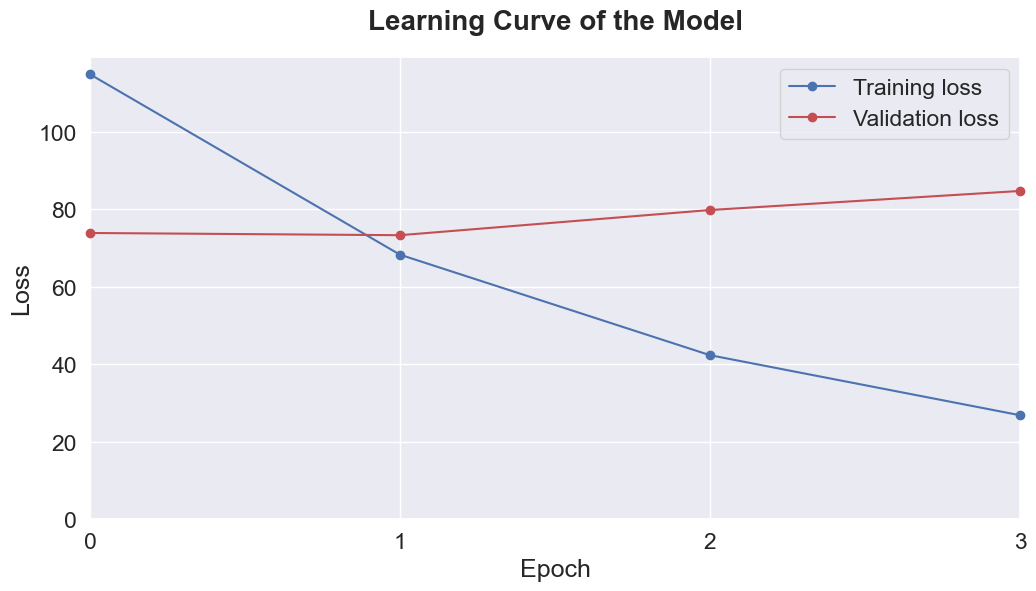

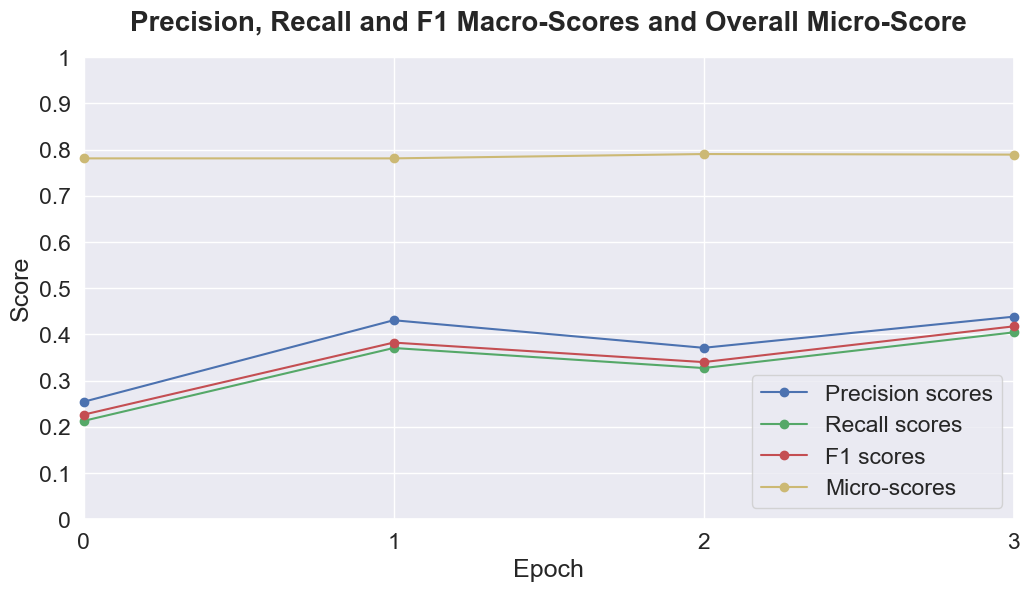

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_and_save_loss_and_scores(loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores):
    """plot loss values / validation loss values and precision, recall, f1 scores in a plot each.
    Save the plots in the local directory
    
    Args:
        loss_values (list): Description
        validation_loss_values (list): Description
        precision_scores (list): Description
        recall_scores (list): Description
        f1_scores (list): Description
    """
    # ========================================
    #           general parameters
    # ========================================

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase font size.
    sns.set(font_scale=1.5)

    # axes style
    sns.axes_style(style='ticks')

    # Increase plot size
    plt.rcParams["figure.figsize"] = (12,6) 

    # ========================================
    #               First plot
    # ========================================

    plt.figure(1)
    plt.xticks(np.arange(0, len(loss_values), step = 1))

    # Plot training loss and validation loss over the epochs.
    plt.plot(loss_values, 'b-o', label="Training loss", clip_on=False, zorder=100) # the higher the zorder the more an element is "pushed" to the foreground
    plt.plot(validation_loss_values, 'r-o', label="Validation loss", clip_on=False, zorder=100)

    # Title of the first plot.
    plt.title(label='Learning Curve of the Model',
              fontsize=20,
              fontweight='bold',
              pad=20)

    # label of the x/y axis
    plt.xlabel("Epoch")
    plt.ylabel("Loss") 

    # minimum and maximum value for x and y axis
    plt.xlim([0,len(loss_values) - 1])
    plt.ylim(ymin=0)

    # show the legend
    plt.legend()

    # save the plot to the speicified path
    plt.savefig('graphics\\loss.svg', bbox_inches='tight')

    # ========================================
    #               Second plot
    # ========================================

    micros = [p[1] for p in f1_scores]
    precision_scores = [p[0] for p in precision_scores]
    recall_scores = [p[0] for p in recall_scores]
    f1_scores = [p[0] for p in f1_scores]
    
    plt.figure(2)
    plt.xticks(np.arange(0, len(f1_scores), step = 1))
    plt.yticks(np.arange(0, 1.1, step = 0.1), (0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1))

    # Plot precision, recall and f1 scores over the epochs
    plt.plot(precision_scores, 'b-o', label="Precision scores", clip_on=False, zorder=100)
    plt.plot(recall_scores, 'g-o', label="Recall scores", clip_on=False, zorder=100)
    plt.plot(f1_scores, 'r-o', label="F1 scores", clip_on=False, zorder=100)
    plt.plot(micros, 'y-o', label="Micro-scores", clip_on=False, zorder=100)

    # Title of second plot.
    plt.title(label='Precision, Recall and F1 Macro-Scores and Overall Micro-Score',
              fontsize=20,
              fontweight='bold',
              pad=20) # for each epoch in the validation phase

    # label of the x/y axis
    plt.xlabel("Epoch")
    plt.ylabel("Score") 

    # minimum and maximum value for x and y axis
    plt.xlim([0,len(precision_scores) - 1])
    plt.ylim([0,1])

    # show the legend
    plt.legend()

    # save the plot to the speicified path
    plt.savefig('graphics\\scores.svg', bbox_inches='tight') 

    # plt.show()

plot_and_save_loss_and_scores(loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores)

### get testing dataloader (external python script handles this)

In [10]:
from get_dataloader import get_dataloader
test_dataloader, _, _ = get_dataloader(config.test_path, 
                                                      data_kind="test", 
                                                      tag_values=tag_values,
                                                      bert_model=config.bert_model, 
                                                      dev=config.dev, 
                                                      sequence_length=config.sequence_length, 
                                                      batch_size=config.batch_size)

{'O': 16546, 'B-Term': 348, 'I-Term': 487, 'B-Definition': 312, 'I-Definition': 4184, 'B-Secondary-Definition': 18, 'I-Secondary-Definition': 303, 'B-Alias-Term': 40, 'B-Referential-Term': 5, 'B-Referential-Definition': 16, 'I-Referential-Definition': 44, 'I-Alias-Term': 32, 'B-Qualifier': 1, 'I-Qualifier': 3, 'B-Definition-frag': 3, 'I-Definition-frag': 52, 'I-Referential-Term': 9, 'B-Ordered-Term': 1, 'I-Ordered-Term': 2, 'B-Ordered-Definition': 1, 'I-Ordered-Definition': 10}

Total sentences:  1189
Total labels:  22417

Following tags and their corresponding IDs will be used:  {'B-Alias-Term': 0, 'B-Alias-Term-frag': 1, 'B-Definition': 2, 'B-Definition-frag': 3, 'B-Ordered-Definition': 4, 'B-Ordered-Term': 5, 'B-Qualifier': 6, 'B-Referential-Definition': 7, 'B-Referential-Term': 8, 'B-Secondary-Definition': 9, 'B-Term': 10, 'B-Term-frag': 11, 'I-Alias-Term': 12, 'I-Definition': 13, 'I-Definition-frag': 14, 'I-Ordered-Definition': 15, 'I-Ordered-Term': 16, 'I-Qualifier': 17, 'I-Refer

### (if necessary) load a model checkpoint

In [11]:
# IMPORTANT: before loading checkpoint, all config specifications must be the same as the model was trained beforehand. 
# This can be checked out through the config object in the saved checkpoint
def load_checkpoint(path, model=None, optimizer=None, scheduler=None):
    """method for loading a checkpoint of model training
    
    Args:
        model (TYPE): initialised model 
        optimizer (TYPE): initialised optimizer
        scheduler (TYPE): initialised scheduler
        path (string): path to trained checkpoint
    
    Returns:
        epoch (int), tag_values (list), loss_values (list), validation_loss_values (list):
        returns the epoch of the checkpoint, used tag_values during training,
        collected loss values and validation loss values
    """
    checkpoint = torch.load(path)
    epoch = checkpoint['epoch']
    if model is not None:
        model.load_state_dict(checkpoint['state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler'])
    tag_values = checkpoint['tag_values'] 
    loss_values = checkpoint['loss_values']
    validation_loss_values = checkpoint['validation_loss_values']
    precision_scores = checkpoint['precision_scores']
    recall_scores = checkpoint['recall_scores']
    f1_scores = checkpoint['f1_scores']

    if "config" in checkpoint:
        config_obj = checkpoint['config']
        return epoch, tag_values, loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores, config_obj
    else:
        return epoch, tag_values, loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores
    
checkpoint = load_checkpoint('C:/Users/Hasan/Desktop/Barcelona_Data/FIB_Courses/HLE/Project/code_repo/HLE_Project/model_checkpoints/scibert-cased-crf-augmented/checkpoint_scibert_augmentation_4.pt', model, optimizer, scheduler) # "model_checkpoints/scibert-cased-crf/checkpoint_scibert_4.pt" 'C:/Users/Hasan/Desktop/Barcelona_Data/FIB_Courses/HLE/Project/code_repo/HLE_Project/model_checkpoints/scibert-cased-crf-augmented/checkpoint_scibert_augmentation_4.pt'

### apply the model on the test set and print a classification report containing the relevant scores

In [12]:
# apply model to test set
def test(model, test_dataloader, tag_values, tag2idx):
    """testing of the BERT model (BERT + BertForTokenClasssification or BERT + CRF)
    based on a test set.

    Args:
        model (TYPE): Description
        test_dataloader (TYPE): Description
        tag_values (TYPE): Description
        tag2idx (TYPE): Description
    
    Returns:
        TYPE: Description
    """
    # for time measurement
    startTime = time.time()

    # put the model in eval-mode, no parameters are optimized in testing phase
    model.eval()

    eval_loss = 0
    predictions, true_labels = [], []
    for batch_number, batch in enumerate(test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels, b_filter_mask = batch
        if config.use_crf:
            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():   
                # This will return the predictions rather than the loss because we have not provided labels.
                logits = model(b_input_ids,
                               token_type_ids=None,
                               attention_mask = b_input_mask)

            # # filter to relevant logits
            masked_logits = apply_masked_select(pad_and_tensor_logits(logits, tag2idx), b_filter_mask)

            # filter to relevant labels
            masked_b_labels = apply_masked_select(b_labels, b_filter_mask)

            predictions.extend(masked_logits) 
            true_labels.extend(masked_b_labels)

            assert len(predictions) == len(true_labels) and len(masked_logits) == len(masked_b_labels), "Please check if the length of predictions and that of true labels are identical."
        else:
            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions and validation loss.   
                # This will return the TokenClassifierOutput as in training (see documentation BertForTokenClassification).
                outputs = model(b_input_ids, 
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels) # token_type_ids=None,

            # Move logits and labels to CPU
            logits = outputs[1].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # get the evaluation loss.
            eval_loss += outputs[0].mean().item()
            # get the labels by taking the argmax of the softmax output and put it into predictions
            predicted_labels = [list(p) for p in np.argmax(logits, axis=2)]
            predictions.extend(predicted_labels) #
            # add the true labels to true_labels for comparing with predictions 
            true_labels.extend(label_ids) 
        
        
    result_precision_score, result_recall_score, result_f1_score, result_classification_report = calculate_relevant_metrics(true_labels, predictions, tag2idx)

    print("Test Precision: {}".format(result_precision_score))
    print("Test Recall: {}".format(result_recall_score))
    print("Test F1-Score: {}".format(result_f1_score))
    
    print("Classification_report: \n {} \n".format(result_classification_report))

    print("TESTING ACCOMPLISHED ! \n")

    endTime = time.time() - startTime
    print(f'whole Testing time: {endTime / 3600} hours')

    return result_precision_score, result_recall_score, result_f1_score, result_classification_report

# test the model
evaluation = test(model, test_dataloader, tag_values, tag2idx)

C:\Users\Hasan\anaconda3\envs\pytorch-nlp\lib\site-packages\torchcrf\__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorCompare.cpp:413.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
C:\Users\Hasan\AppData\Local\Temp\ipykernel_19832\216032391.py:71: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())


Test Precision: [0.5174482029987, 0.7519176800748363]
Test Recall: [0.5085569332672744, 0.7272891784292436]
Test F1-Score: [0.5075962438565269, 0.7393983994112777]
Classification_report: 
 {'B-Term': {'precision': 0.7492625368731564, 'recall': 0.7298850574712644, 'f1-score': 0.7394468704512374, 'support': 348}, 'I-Term': {'precision': 0.7137014314928425, 'recall': 0.7022132796780685, 'f1-score': 0.7079107505070994, 'support': 497}, 'B-Definition': {'precision': 0.6515679442508711, 'recall': 0.5993589743589743, 'f1-score': 0.6243739565943239, 'support': 312}, 'I-Definition': {'precision': 0.7677088422081094, 'recall': 0.7449632614363594, 'f1-score': 0.7561650427041983, 'support': 4219}, 'B-Alias-Term': {'precision': 0.7333333333333333, 'recall': 0.55, 'f1-score': 0.6285714285714286, 'support': 40}, 'I-Alias-Term': {'precision': 0.24, 'recall': 0.1875, 'f1-score': 0.21052631578947367, 'support': 32}, 'B-Referential-Definition': {'precision': 0.8125, 'recall': 0.8125, 'f1-score': 0.8125, 

## Error Analysis of SciBERT+CRF (best model): the following section analyzes the model with respect to its errors

### first a confusion matrix is created

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from scikitplot import metrics

def calculate_confusion_matrix(y_true: list, y_pred: list, tag2idx: dict):
    """The classification metrics precision, recall and f1-score are calculated and returned.
    If wanted a classification report can be returned. It contains the above mentioned metrics
    for all labels.
    
    Args:
        y_true (list): Description
        y_pred (list): Description
        tag_values (list): Description
        report_wanted (bool, optional): Description
    
    Returns:
        TYPE: Description
    """
    
    y_true = [item for sublist in y_true for item in sublist]
    y_pred = [item for sublist in y_pred for item in sublist]
    
    relevant_labels_for_evaluation = [tag2idx['O'], tag2idx['B-Term'], tag2idx['I-Term'], tag2idx['B-Definition'], tag2idx['I-Definition'], tag2idx['B-Alias-Term'], tag2idx['I-Alias-Term'], tag2idx['B-Referential-Definition'], tag2idx['I-Referential-Definition'], tag2idx['B-Referential-Term'], tag2idx['I-Referential-Term'], tag2idx['B-Qualifier'], tag2idx['I-Qualifier']]
    target_names = ['O', 'B-Term', 'I-Term', 'B-Definition', 'I-Definition', 'B-Alias-Term', 'I-Alias-Term', 'B-Ref.-Def.', 'I-Ref.-Def.', 'B-Ref.-Term', 'I-Ref.-Term', 'B-Qualifier', 'I-Qualifier']
    
    # make copy of tag2idx
    new_tag2idx = dict(tag2idx)
    new_tag2idx['B-Ref.-Def.'] = new_tag2idx.pop('B-Referential-Definition')
    new_tag2idx['I-Ref.-Def.'] = new_tag2idx.pop('I-Referential-Definition')
    new_tag2idx['B-Ref.-Term'] = new_tag2idx.pop('B-Referential-Term')
    new_tag2idx['I-Ref.-Term'] = new_tag2idx.pop('I-Referential-Term')
    
    # inverse of tag2idx
    inv_tag2idx = {v: k for k, v in new_tag2idx.items()}
    y_true_transformed = [inv_tag2idx[i] for i in y_true]
    y_pred_transformed = [inv_tag2idx[i] for i in y_pred]
    
    metrics.plot_confusion_matrix(y_true_transformed, y_pred_transformed, labels=target_names, title=None, normalize=True, hide_zeros=True, hide_counts=False, x_tick_rotation=-90, ax=None, figsize=None, cmap='Blues', title_fontsize='large', text_fontsize='medium')
    
    return y_true, y_pred, confusion_matrix(y_true, y_pred, labels=relevant_labels_for_evaluation)

Length of test dataloader:  4


C:\Users\Hasan\AppData\Local\Temp\ipykernel_19832\216032391.py:71: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())


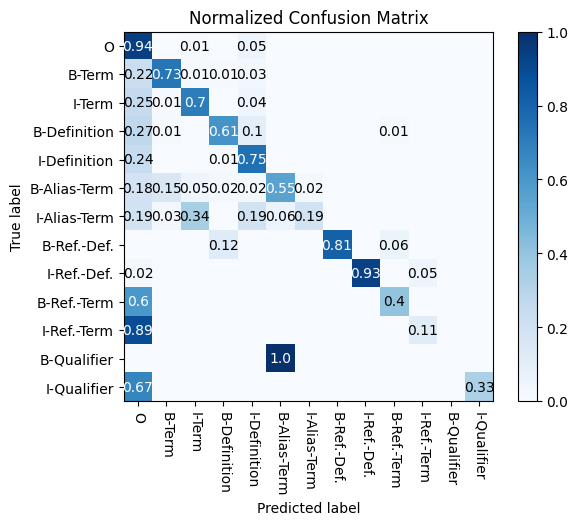

In [14]:
# make confusion matrix
def error_analysis(model, test_dataloader, tag_values, tag2idx):

    # put the model in eval-mode, no parameters are optimized in testing phase
    model.eval()

    eval_loss = 0
    predictions, true_labels = [], []
    
    print("Length of test dataloader: ", len(test_dataloader))
    for batch_number, batch in enumerate(test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels, b_filter_mask = batch
        
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():   
            # This will return the predictions rather than the loss because we have not provided labels.
            logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask = b_input_mask)

        # filter to relevant logits
        masked_logits = apply_masked_select(pad_and_tensor_logits(logits, tag2idx), b_filter_mask)

        # filter to relevant labels
        masked_b_labels = apply_masked_select(b_labels, b_filter_mask)

        predictions.extend(masked_logits) 
        true_labels.extend(masked_b_labels)

        assert len(predictions) == len(true_labels) and len(masked_logits) == len(masked_b_labels), "Please check if the length of predictions and that of true labels are identical."
        
    conf_matrix = calculate_confusion_matrix(true_labels, predictions, tag2idx)
        
    return conf_matrix

# get confusion matrix
y_true, y_pred, cm = error_analysis(model, test_dataloader, tag_values, tag2idx)

### manually selecting interesting examples of model missclassifications

In [37]:
# make error analysis
def get_all_logits(model, test_dataloader):

    # put the model in eval-mode, no parameters are optimized in testing phase
    model.eval()

    all_logits = []
    
    print("Length of test dataloader: ", len(test_dataloader))
    for batch_number, batch in enumerate(test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels, b_filter_mask = batch
        
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():   
            # This will return the predictions rather than the loss because we have not provided labels.
            logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask = b_input_mask)
        #print(len(logits))
        all_logits.append(logits)
  
    return all_logits

In [38]:
all_logits = get_all_logits(model, test_dataloader)

Length of test dataloader:  4


In [72]:
import numpy

all_batches = []
for batch_number, batch in enumerate(test_dataloader):
    batch = tuple(t.to('cpu') for t in batch)
    all_batches.append(batch)

needed_tensor = []

# search in true label
search_id = tag2idx['B-Referential-Definition'] # B-Referential-Definition / I-Alias-Term
# search in classifications
lookup_id = tag2idx['B-Definition'] # B-Definition / I-Term

# go through all batches of size 4 or 5
for index, b in enumerate(all_batches):
    # assign to variables
    b_input_ids, b_input_mask, b_labels, b_filter_mask = b
    # print(len(b_input_ids))
    
    # go through one batch of size 16
    for i in range(len(b_input_ids)):
        input_ids, input_mask, labels, filter_mask = b_input_ids[i], b_input_mask[i], b_labels[i], b_filter_mask[i]
        input_ids = torch.masked_select(input_ids, input_mask)
        labels = torch.masked_select(labels, input_mask)
        #print(len(input_ids))
        #if search_id in labels:
            #print("Found searched label in true labels")
        
        #go through one 
        for lab_index, lab in enumerate(labels):
            if (search_id == lab):
                #print(lab, all_logits[index][i][lab_index])
                if (all_logits[index][i][lab_index] == lookup_id):
                    needed_tensor.append((index, i, lab_index))

C:\Users\Hasan\AppData\Local\Temp\ipykernel_19832\2087569231.py:24: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1730.)
  input_ids = torch.masked_select(input_ids, input_mask)
C:\Users\Hasan\AppData\Local\Temp\ipykernel_19832\2087569231.py:25: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1730.)
  labels = torch.masked_select(labels, input_mask)


In [73]:
needed_tensor

[(1, 4, 312), (1, 4, 325)]

In [19]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(config.bert_model, do_lower_case=False)

In [74]:
input_ids, input_mask, labels, filter_mask = all_batches[1] # 0 / 1
classified_labels = all_logits[1] # 0 / 1

needed_batch_number = 4 # 7 / 4

input_ids_filtered = torch.masked_select(input_ids[needed_batch_number], input_mask[needed_batch_number])
labels_filtered = torch.masked_select(labels[needed_batch_number], input_mask[needed_batch_number])
classified_labels_filtered = classified_labels[needed_batch_number]

C:\Users\Hasan\AppData\Local\Temp\ipykernel_19832\3268713975.py:6: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1730.)
  input_ids_filtered = torch.masked_select(input_ids[needed_batch_number], input_mask[needed_batch_number])
C:\Users\Hasan\AppData\Local\Temp\ipykernel_19832\3268713975.py:7: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1730.)
  labels_filtered = torch.masked_select(labels[needed_batch_number], input_mask[needed_batch_number])


In [75]:
tokens = tokenizer.convert_ids_to_tokens(input_ids_filtered.numpy())
for token, label in zip(tokens[300:330], labels_filtered[300:330]): # 270:303 / 300:330
    print("{}\t\t\t{}".format(tag_values[label], token))

I-Definition			in
I-Definition			the
I-Definition			nuclei
I-Definition			of
I-Definition			the
I-Definition			atoms
I-Definition			and
I-Definition			have
I-Definition			other
I-Definition			unique
I-Definition			characteristics
O			.
B-Referential-Definition			The
I-Referential-Definition			emission
I-Referential-Definition			of
I-Referential-Definition			these
I-Referential-Definition			rays
O			is
O			called
B-Term			nuclear
I-Term			radioactivity
O			or
O			simply
B-Alias-Term			radioactivity
O			.
B-Referential-Definition			The
I-Referential-Definition			emission
I-Referential-Definition			of
I-Referential-Definition			these
I-Referential-Definition			rays


In [76]:
tokens = tokenizer.convert_ids_to_tokens(input_ids_filtered.numpy())
for token, label in zip(tokens[300:330], classified_labels_filtered[300:330]): # 270:303 / 300:330
    print("{}\t\t\t{}".format(tag_values[label], token))

O			in
O			the
O			nuclei
O			of
O			the
O			atoms
O			and
O			have
O			other
O			unique
O			characteristics
O			.
B-Definition			The
I-Referential-Definition			emission
I-Referential-Definition			of
O			these
I-Referential-Definition			rays
O			is
O			called
B-Term			nuclear
I-Term			radioactivity
O			or
O			simply
I-Term			radioactivity
O			.
B-Definition			The
I-Referential-Definition			emission
I-Referential-Definition			of
I-Referential-Definition			these
I-Referential-Definition			rays


### if sub tokens should already be merged to full words

In [52]:
tokens = tokenizer.convert_ids_to_tokens(input_ids_filtered.numpy())
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, labels_filtered):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [36]:
for token, label in zip(new_tokens[299:], new_labels[299:]):
    print("{}\t\t\t{}".format(label, token))

O			2080
O			.
O			For
O			example
O			,
O			in
O			the
O			English
O			Channel
O			ecosystem
O			the
O			primary
O			producers
O			account
O			for
O			a
O			biomass
O			of
O			4
O			g
O			/
O			m2
O			(
O			grams
O			per
O			meter
O			squared
O			)
O			,
O			while
O			the
O			primary
O			consumers
O			exhibit
O			a
O			biomass
O			of
O			21
O			g
O			/
O			m2
O			.
O			The
O			productivity
O			of
O			the
O			primary
O			producers
O			is
O			especially
O			important
O			in
O			any
O			ecosystem
O			because
O			these
O			organisms
O			bring
O			energy
O			to
O			other
O			living
O			organisms
O			by
O			photoautotrophy
O			or
O			chemoautotrophy
O			.
B-Definition			The
I-Definition			rate
I-Definition			at
I-Definition			which
I-Definition			photosynthetic
I-Definition			primary
I-Definition			producers
I-Definition			incorporate
I-Definition			energy
I-Definition			from
I-Definition			the
I-Definition			sun
O			is
O			called
B-Term			gross
I-Term			primary
I-Term			productivity
O			.


### formatting results (for report writing)

In [60]:
best_results = {'B-Term': {'precision': 0.7492625368731564, 'recall': 0.7298850574712644, 'f1-score': 0.7394468704512374, 'support': 348}, 'I-Term': {'precision': 0.7137014314928425, 'recall': 0.7022132796780685, 'f1-score': 0.7079107505070994, 'support': 497}, 'B-Definition': {'precision': 0.6515679442508711, 'recall': 0.5993589743589743, 'f1-score': 0.6243739565943239, 'support': 312}, 'I-Definition': {'precision': 0.7677088422081094, 'recall': 0.7449632614363594, 'f1-score': 0.7561650427041983, 'support': 4219}, 'B-Alias-Term': {'precision': 0.7333333333333333, 'recall': 0.55, 'f1-score': 0.6285714285714286, 'support': 40}, 'I-Alias-Term': {'precision': 0.24, 'recall': 0.1875, 'f1-score': 0.21052631578947367, 'support': 32}, 'B-Referential-Definition': {'precision': 0.8125, 'recall': 0.8125, 'f1-score': 0.8125, 'support': 16}, 'I-Referential-Definition': {'precision': 0.8913043478260869, 'recall': 0.9318181818181818, 'f1-score': 0.9111111111111111, 'support': 44}, 'B-Referential-Term': {'precision': 0.25, 'recall': 0.4, 'f1-score': 0.3076923076923077, 'support': 5}, 'I-Referential-Term': {'precision': 0.2, 'recall': 0.1111111111111111, 'f1-score': 0.14285714285714285, 'support': 9}, 'B-Qualifier': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'I-Qualifier': {'precision': 0.2, 'recall': 0.3333333333333333, 'f1-score': 0.25, 'support': 3}, 'micro avg': {'precision': 0.7519176800748363, 'recall': 0.7272891784292436, 'f1-score': 0.7393983994112777, 'support': 5526}, 'macro avg': {'precision': 0.5174482029987, 'recall': 0.5085569332672744, 'f1-score': 0.5075962438565269, 'support': 5526}, 'weighted avg': {'precision': 0.7511014301128789, 'recall': 0.7272891784292437, 'f1-score': 0.7388286115647277, 'support': 5526}} 

In [61]:
for a in best_results:
    print(a, [round(c, 4) for c in best_results[a].values()])

B-Term [0.7493, 0.7299, 0.7394, 348]
I-Term [0.7137, 0.7022, 0.7079, 497]
B-Definition [0.6516, 0.5994, 0.6244, 312]
I-Definition [0.7677, 0.745, 0.7562, 4219]
B-Alias-Term [0.7333, 0.55, 0.6286, 40]
I-Alias-Term [0.24, 0.1875, 0.2105, 32]
B-Referential-Definition [0.8125, 0.8125, 0.8125, 16]
I-Referential-Definition [0.8913, 0.9318, 0.9111, 44]
B-Referential-Term [0.25, 0.4, 0.3077, 5]
I-Referential-Term [0.2, 0.1111, 0.1429, 9]
B-Qualifier [0.0, 0.0, 0.0, 1]
I-Qualifier [0.2, 0.3333, 0.25, 3]
micro avg [0.7519, 0.7273, 0.7394, 5526]
macro avg [0.5174, 0.5086, 0.5076, 5526]
weighted avg [0.7511, 0.7273, 0.7388, 5526]
